## imports

In [487]:
import pandas as pd
import requests 
import json
import matplotlib.pyplot as plt
from plotnine import *
import numpy as np
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

from mizani.breaks import date_breaks
from mizani.formatters import date_format


## methods

In [488]:
def get_data_all(x) -> pd.DataFrame:
    r = requests.get('https://glusfqycvwrucp9-db202202211424.adb.eu-zurich-1.oraclecloudapps.com/ords/sensor_datalake2/sens/any_sensor_data_entry/',auth=('SENSOR_DATALAKE2', 'smarTclassrooM2Da'), params={"limit":50000, "offset":x * 10_000})

    df = pd.json_normalize(r.json()["items"])

    df.set_index(pd.DatetimeIndex(df["inserttime"]), inplace=True)
    df.drop("inserttime", axis=1, inplace=True)
    df.sort_index(inplace=True)

    return df

def show_data(data:pd.DataFrame):
    x = data.index.values

    device1_hum = data["device1humidity"].values
    device2_hum = data["device2humidity"].values
    device3_hum = data["device3humidity"].values

    device1_co2 = data["device1co2"].values
    device2_co2 = data["device2co2"].values
    device3_co2 = data["device3co2"].values

    device1_temp = data["device1temp"].values
    device2_temp = data["device2temp"].values
    device3_temp = data["device3temp"].values

    device3_window1 = data["device3window1a"].values
    device3_window2 = data["device3window2b"].values
    device3_window3 = data["device3window3a"].values
    device3_window4 = data["device3window4b"].values
    device3_window5 = data["device3window5a"].values

    device1_light = data["device1light"].values
    device2_light = data["device2light"].values
    device3_light = data["device3light"].values

    fig, ax = plt.subplots(5, 1, sharex=True, figsize=(15,15))

    ax[0].set_title("Humidity")
    ax[0].plot(x, device1_hum, label="Device1")
    ax[0].plot(x, device2_hum, label="Device2")
    ax[0].plot(x, device3_hum, label="Device3")
    ax[0].legend(loc="right")
    ax[0].set_ylabel("Humidity in %")

    ax[1].set_title("CO2")
    ax[1].plot(x, device1_co2, label="Device1")
    ax[1].plot(x, device2_co2, label="Device2")
    ax[1].plot(x, device3_co2, label="Device3")
    ax[1].legend(loc="right")
    ax[1].set_ylabel("CO2 in ppM")

    ax[2].set_title("Temperature")
    ax[2].plot(x, device1_temp, label="Device1")
    ax[2].plot(x, device2_temp, label="Device2")
    ax[2].plot(x, device3_temp, label="Device3")
    ax[2].legend(loc="right")
    ax[2].set_ylabel("Temperature in °C")

    ax[3].set_title("Lightstrength")
    ax[3].plot(x, device1_light, label="Device1")
    ax[3].plot(x, device2_light, label="Device2")
    ax[3].plot(x, device3_light, label="Device3")
    ax[3].legend(loc="right")
    ax[3].set_ylabel("Lightstrength in lumen")

    ax[4].set_title("Window")
    ax[4].plot(x, device3_window1, label="Window1")
    ax[4].plot(x, device3_window2, label="Window2")
    ax[4].plot(x, device3_window3, label="Window3")
    ax[4].plot(x, device3_window4, label="Window4")
    ax[4].plot(x, device3_window5, label="Window5")
    ax[4].legend(loc="right")
    ax[4].set_yticks([0, 1])
    ax[4].set_yticklabels(["closed", "open"])
    ax[4].set_ylabel("State [open; closed]")


In [489]:
#Da immer nur 10'000 Zeilen mit einer Abfrage geholt werden können, werden diese in mehrere df gespeichert und danach zusammengeführt.
#In den Klammern immer die Nummer des jeweiligen df angeben (Dann nimmt immer die nächsten Zeilen)
df0 = get_data_all(0)
df1 = get_data_all(1)
df2 = get_data_all(2)
df3 = get_data_all(3)
df4 = get_data_all(4)

#df Zusammenführen
df = pd.concat([df0, df1, df2, df3, df4], axis=0)

#Sicherheitshalber nochmals sortieren
df = df.sort_values(by="inserttime")

#2 Neue Spalten hinzufügen, für Anzahl Personen im Klassenzimmer und Fächer
df = df.assign(numberOfPeople = 0, subject = "Nichts")

In [519]:
#df erwitern anhand Klassenliste (welche von den Lehrern ausgefüllt wurde)
#04.04.2022
mask = (df.index > pd.to_datetime("04042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("04042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 18
df.loc[mask, "subject"] = "Allg."

mask = (df.index > pd.to_datetime("04042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("04042022 09:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 16
df.loc[mask, "subject"] = "Allg."

mask = (df.index > pd.to_datetime("04042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("04042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 17
df.loc[mask, "subject"] = "Allg."

mask = (df.index > pd.to_datetime("04042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("04042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 16
df.loc[mask, "subject"] = "Allg."
#05.04.2022
mask = (df.index > pd.to_datetime("05042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("05042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 21
df.loc[mask, "subject"] = "Allg."

mask = (df.index > pd.to_datetime("05042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("05042022 09:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 10
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("05042022 09:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("05042022 10:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 10
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("05042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("05042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 11
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("05042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("05042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 11
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("05042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("05042022 14:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 1
df.loc[mask, "subject"] = "Mittag"

mask = (df.index > pd.to_datetime("05042022 14:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("05042022 14:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 19
df.loc[mask, "subject"] = "Französisch"
#06.04.2022
mask = (df.index > pd.to_datetime("06042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("06042022 08:20:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 19
df.loc[mask, "subject"] = "Ganzklass"

mask = (df.index > pd.to_datetime("06042022 10:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("06042022 10:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 8
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("06042022 10:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("06042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 1
df.loc[mask, "subject"] = "Pause"

mask = (df.index > pd.to_datetime("06042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("06042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 10
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("06042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("06042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 11
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("06042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("06042022 12:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 2
df.loc[mask, "subject"] = "Mittag"

mask = (df.index > pd.to_datetime("06042022 14:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("06042022 15:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 4
df.loc[mask, "subject"] = "Elterngespräch"
#07.04.2022
mask = (df.index > pd.to_datetime("07042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("07042022 08:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 20
df.loc[mask, "subject"] = "Ganzklass"

mask = (df.index > pd.to_datetime("07042022 08:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("07042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 10
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("07042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("07042022 09:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 20
df.loc[mask, "subject"] = "Ganzklass"

mask = (df.index > pd.to_datetime("07042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("07042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 10
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("07042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("07042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 11
df.loc[mask, "subject"] = "Abteilung"
#08.04.2022
mask = (df.index > pd.to_datetime("08042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("08042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 22
df.loc[mask, "subject"] = "Französisch"

mask = (df.index > pd.to_datetime("08042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("08042022 09:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 22
df.loc[mask, "subject"] = "Ganzklass"

mask = (df.index > pd.to_datetime("08042022 09:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("08042022 10:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 23
df.loc[mask, "subject"] = "Ganzklass"

mask = (df.index > pd.to_datetime("08042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("08042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 22
df.loc[mask, "subject"] = "Ganzklass"

mask = (df.index > pd.to_datetime("08042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("08042022 12:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 2
df.loc[mask, "subject"] = "Mittag"
#11.04.2022
mask = (df.index > pd.to_datetime("11042022 12:40:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("11042022 14:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 1
df.loc[mask, "subject"] = "3 Tageblock"

mask = (df.index > pd.to_datetime("11042022 14:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("11042022 15:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 2
df.loc[mask, "subject"] = "3 Tageblock"

mask = (df.index > pd.to_datetime("11042022 15:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("11042022 18:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 1
df.loc[mask, "subject"] = "3 Tageblock"
#12.04.2022
mask = (df.index > pd.to_datetime("12042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("12042022 11:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 1
df.loc[mask, "subject"] = "3 Tageblock"

mask = (df.index > pd.to_datetime("12042022 11:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("12042022 12:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 3
df.loc[mask, "subject"] = "3 Tageblock"
#13.04.2022
mask = (df.index > pd.to_datetime("13042022 12:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("13042022 15:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 1
df.loc[mask, "subject"] = "3 Tageblock"
#25.04.2022
mask = (df.index > pd.to_datetime("25042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("25042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 19
df.loc[mask, "subject"] = "Allgemein"

mask = (df.index > pd.to_datetime("25042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("25042022 09:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 17
df.loc[mask, "subject"] = "Allgemein"

mask = (df.index > pd.to_datetime("25042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("25042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 18
df.loc[mask, "subject"] = "Allgemein"

mask = (df.index > pd.to_datetime("25042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("25042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 17
df.loc[mask, "subject"] = "Allgemein"

mask = (df.index > pd.to_datetime("25042022 12:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("25042022 16:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 1
df.loc[mask, "subject"] = "Allgemein"
#26.04.2022
mask = (df.index > pd.to_datetime("26042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("26042022 09:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 21
df.loc[mask, "subject"] = "Ganzklass"

mask = (df.index > pd.to_datetime("26042022 09:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("26042022 09:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 10
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("26042022 10:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("26042022 10:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 12
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("26042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("26042022 11:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 13
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("26042022 11:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("26042022 11:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 8
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("26042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("26042022 12:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 2
df.loc[mask, "subject"] = "Vorleseeinheiten"
#27.04.2022
mask = (df.index > pd.to_datetime("27042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("27042022 08:20:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 22
df.loc[mask, "subject"] = "Ganzklass"

mask = (df.index > pd.to_datetime("27042022 10:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("27042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 11
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("27042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("27042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 10
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("27042022 17:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("27042022 17:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 1
df.loc[mask, "subject"] = "Vorleseeinheiten"
#28.04.2022
mask = (df.index > pd.to_datetime("28042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("28042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 13
df.loc[mask, "subject"] = "Abteilung"

mask = (df.index > pd.to_datetime("28042022 08:45:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("28042022 10:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 22
df.loc[mask, "subject"] = "Abteilung"
#29.04.2022
mask = (df.index > pd.to_datetime("29042022 08:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("28042022 10:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 23
df.loc[mask, "subject"] = "Ganzklass"

mask = (df.index > pd.to_datetime("29042022 11:30:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("29042022 12:15:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))
df.loc[mask, "numberOfPeople"] = 22
df.loc[mask, "subject"] = "Ganzklass"

,entryid,device1humidity,device1co2,device1temp,device2humidity,device2co2,device2temp,device3humidity,device3co2,device3temp,...,device3window4b,device3window5a,device1light,device2light,device3light,device1battery,device2battery,device3battery,numberOfPeople,subject
inserttime,,,,,,,,,,,,,,,,,,,,,
2022-04-03 16:57:49+00:00,537,28.3035,360.727,22.6394,29.3671,433.828,22.4445,27.2156,464.521,24.6021,...,0.0,0.0,10.57170,9.30525,12.9165,None,None,None,0,Nichts
2022-04-03 16:59:04+00:00,538,28.4836,361.801,22.6688,29.3304,433.614,22.5032,27.1317,462.388,24.6315,...,0.0,0.0,10.38860,8.81055,12.9165,None,None,None,0,Nichts
2022-04-03 17:00:14+00:00,539,28.4225,367.020,22.6955,29.4586,433.403,22.5460,27.1591,462.645,24.6315,...,0.0,0.0,9.96814,8.87486,12.9314,None,None,None,0,Nichts
2022-04-03 17:01:26+00:00,540,28.3279,369.415,22.7382,29.3198,441.238,22.5460,27.2278,464.077,24.6021,...,0.0,0.0,9.59712,8.45932,12.9413,None,None,None,0,Nichts
2022-04-03 17:02:37+00:00,541,28.3096,367.818,22.7249,29.2557,444.417,22.6020,27.2278,466.831,24.6021,...,0.0,0.0,9.25578,8.06851,12.2883,None,None,None,0,Nichts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03 09:33:05+00:00,45433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Nichts
2022-05-03 09:33:46+00:00,45434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Nichts
2022-05-03 09:34:27+00:00,45435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Nichts


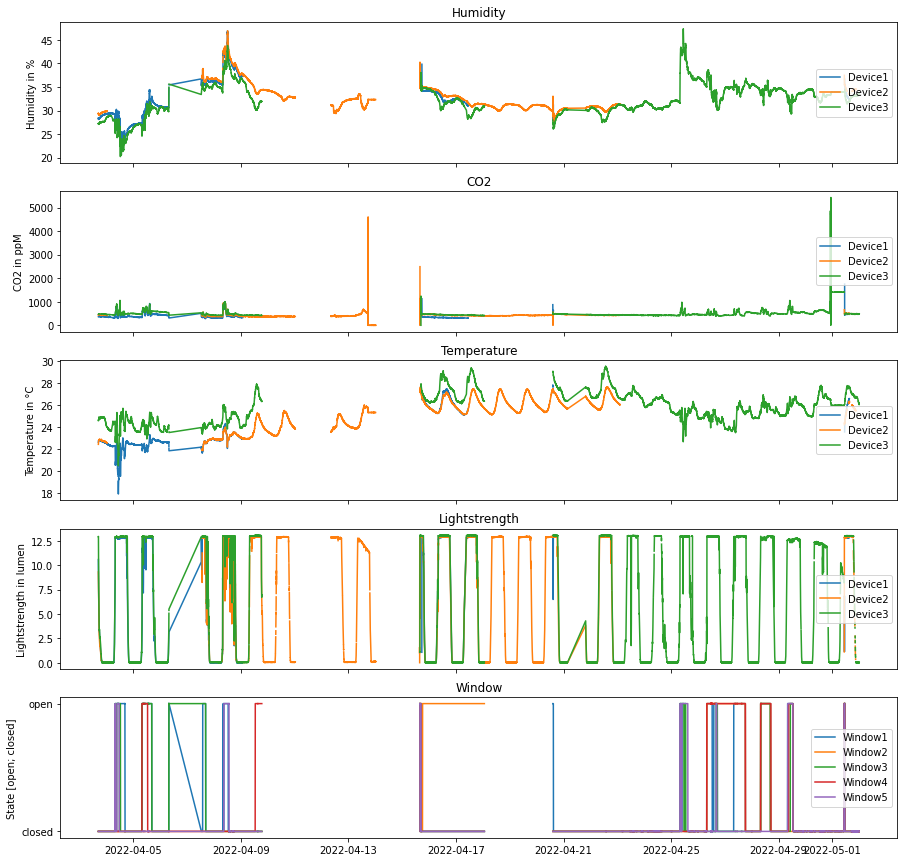

In [491]:
show_data(df)
df

In [492]:
df = df.assign(fensterOffen = 0)
df = df.assign(fensterGekippt = 0)
df = df.assign(fensterKombination = 0)

In [493]:
df["fensterGekippt"]        = df["device3window2b"] + df["device3window4b"]
df["fensterOffen"]          = df["device3window1a"] + df["device3window3a"] + df["device3window5a"]

In [494]:
mask = (df["fensterGekippt"] == 0) & (df["fensterOffen"] == 0)
df.loc[mask, "fensterKombination"] = 0.0

mask = (df["fensterGekippt"] == 0) & (df["fensterOffen"] == 1)
df.loc[mask, "fensterKombination"] = 0.1

mask = (df["fensterGekippt"] == 0) & (df["fensterOffen"] == 2)
df.loc[mask, "fensterKombination"] = 0.2

mask = (df["fensterGekippt"] == 0) & (df["fensterOffen"] == 3)
df.loc[mask, "fensterKombination"] = 0.3

mask = (df["fensterGekippt"] == 1) & (df["fensterOffen"] == 0)
df.loc[mask, "fensterKombination"] = 1.0

mask = (df["fensterGekippt"] == 1) & (df["fensterOffen"] == 1)
df.loc[mask, "fensterKombination"] = 1.1

mask = (df["fensterGekippt"] == 1) & (df["fensterOffen"] == 2)
df.loc[mask, "fensterKombination"] = 1.2

mask = (df["fensterGekippt"] == 1) & (df["fensterOffen"] == 3)
df.loc[mask, "fensterKombination"] = 1.3

mask = (df["fensterGekippt"] == 2) & (df["fensterOffen"] == 0)
df.loc[mask, "fensterKombination"] = 2.0

mask = (df["fensterGekippt"] == 2) & (df["fensterOffen"] == 1)
df.loc[mask, "fensterKombination"] = 2.1

mask = (df["fensterGekippt"] == 2) & (df["fensterOffen"] == 2)
df.loc[mask, "fensterKombination"] = 2.2

mask = (df["fensterGekippt"] == 2) & (df["fensterOffen"] == 3)
df.loc[mask, "fensterKombination"] = 2.3

In [495]:
mask = (df.index > pd.to_datetime("04042022 00:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("04042022 23:59:59", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))

df0404 = df.loc[mask]

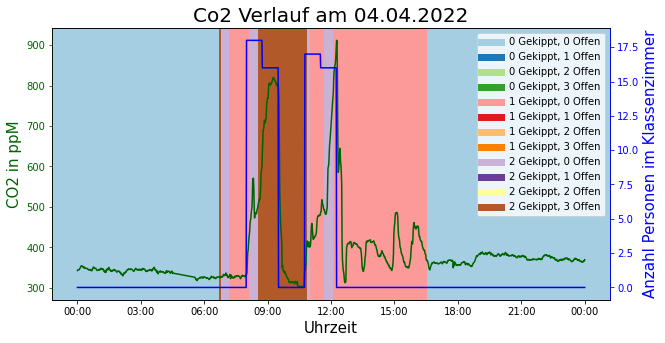

In [496]:
fig,ax1 = plt.subplots(figsize=(10,5))

ax1.plot(df0404.index.values, df0404["device1co2"], color="darkgreen")
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(), df0404["fensterKombination"].values[np.newaxis], cmap="Paired", alpha=1)

ax2 = ax1.twinx()


ax2.plot(df0404.index.values, df0404["numberOfPeople"], color="blue")

ax1.set_ylabel("CO2 in ppM", color="darkgreen", fontsize = 15)
ax2.set_ylabel("Anzahl Personen im Klassenzimmer", color="blue", fontsize = 15)
ax1.set_xlabel("Uhrzeit", color="black", fontsize = 15)

ax1.spines["left"].set_color("darkgreen")
ax2.spines["right"].set_color("blue")
ax1.tick_params(axis="y", colors="darkgreen")
ax2.tick_params(axis="y", colors="blue")

myFmt = mdates.DateFormatter("%H:%M")
ax2.xaxis.set_major_formatter(myFmt)


cmap = plt.cm.Paired
custom_lines = [Line2D([0], [0], color=cmap(0), lw=7),
                Line2D([0], [0], color=cmap(1), lw=7),
                Line2D([0], [0], color=cmap(2), lw=7),
                Line2D([0], [0], color=cmap(3), lw=7),
                Line2D([0], [0], color=cmap(4), lw=7),
                Line2D([0], [0], color=cmap(5), lw=7),
                Line2D([0], [0], color=cmap(6), lw=7),
                Line2D([0], [0], color=cmap(7), lw=7),
                Line2D([0], [0], color=cmap(8), lw=7),
                Line2D([0], [0], color=cmap(9), lw=7),
                Line2D([0], [0], color=cmap(10), lw=7),
                Line2D([0], [0], color=cmap(11), lw=7)]
ax1.legend(custom_lines, ["0 Gekippt, 0 Offen", "0 Gekippt, 1 Offen", "0 Gekippt, 2 Offen", "0 Gekippt, 3 Offen",
                            "1 Gekippt, 0 Offen", "1 Gekippt, 1 Offen", "1 Gekippt, 2 Offen", "1 Gekippt, 3 Offen",
                            "2 Gekippt, 0 Offen", "2 Gekippt, 1 Offen", "2 Gekippt, 2 Offen", "2 Gekippt, 3 Offen"])

plt.title("Co2 Verlauf am 04.04.2022", fontsize = 20)
plt.show()

In [547]:
df0404
df0404.reset_index(inplace=True)

start   = df0404["inserttime"][:-1]
end     = df0404["inserttime"][1:]
colors  = df0404["fensterKombination"][:-1]

start.reset_index(inplace = True, drop = True)
end.reset_index(inplace = True, drop = True)
colors.reset_index(inplace = True, drop = True)

dffenster = pd.DataFrame({"start":start, "end":end, "colors": colors})

df0404 = df0404[:-1]
df0404["fensterKombination"] = df0404["fensterKombination"].astype("category")

<ipython-input-547-78430c33b9d9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


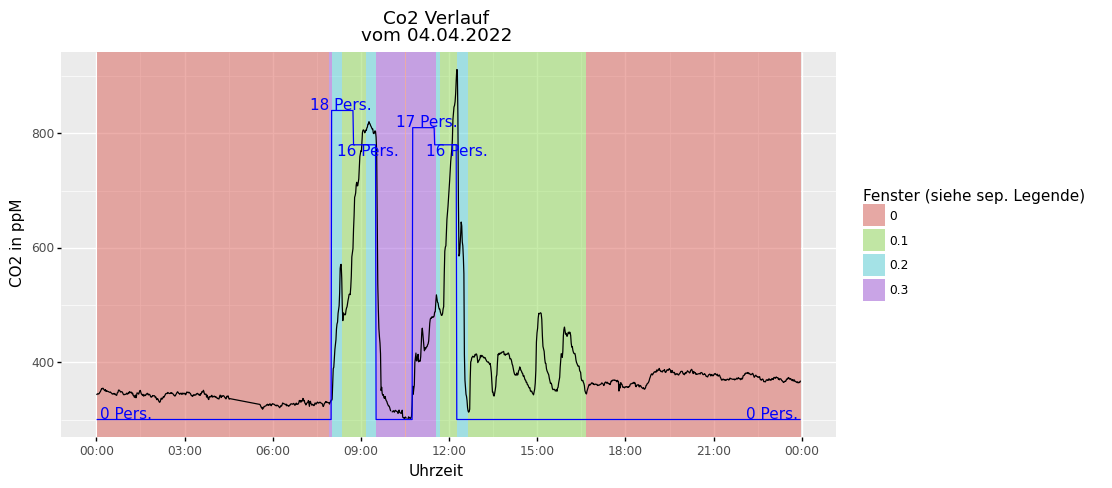

<ggplot: (8769729812643)>

In [548]:
(ggplot()
    + geom_rect(dffenster, aes(xmin = start, xmax = end, ymin = float("-inf"), ymax = float("inf"), fill = colors), alpha = 0.5)
    + geom_line(df0404, aes("inserttime", "device1co2"))
    + geom_line(df0404, aes("inserttime", "30*numberOfPeople+300"), color = "blue")
    + scale_x_date(date_labels = "%H:%M")
    + labs(title = "Co2 Verlauf\nvom 04.04.2022",x = "Uhrzeit", y = "CO2 in ppM", fill = "Fenster (siehe sep. Legende)")
    + theme(figure_size=(10, 5))
    + annotate('text', x=pd.Timestamp("2022-04-04 01:00:00"), y = 310, label="0 Pers.", color = "blue")
    + annotate('text', x=pd.Timestamp("2022-04-04 08:20:00"), y = 850, label="18 Pers.", color = "blue")
    + annotate('text', x=pd.Timestamp("2022-04-04 12:15:00"), y = 770, label="16 Pers.", color = "blue")
    + annotate('text', x=pd.Timestamp("2022-04-04 09:15:00"), y = 770, label="16 Pers.", color = "blue")
    + annotate('text', x=pd.Timestamp("2022-04-04 11:15:00"), y = 820, label="17 Pers.", color = "blue")
    + annotate('text', x=pd.Timestamp("2022-04-04 23:00:00"), y = 310, label="0 Pers.", color = "blue")
    )

Text(0.5, 1.0, 'Co2-Luftfeuchtigkeit (04.04.2022)')

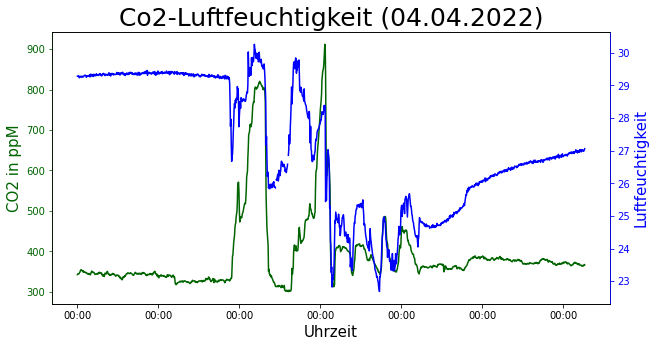

In [499]:
fig,ax1 = plt.subplots(figsize=(10,5))

ax1.plot(df0404.index.values, df0404["device1co2"], color="darkgreen")

ax2 = ax1.twinx()

ax2.plot(df0404.index.values, df0404["device1humidity"], color="blue")

ax1.set_ylabel("CO2 in ppM", color="darkgreen", fontsize = 15)
ax2.set_ylabel("Luftfeuchtigkeit", color="blue", fontsize = 15)
ax1.set_xlabel("Uhrzeit", color="black", fontsize = 15)

myFmt = mdates.DateFormatter("%H:%M")
ax2.xaxis.set_major_formatter(myFmt)

ax1.spines["left"].set_color("darkgreen")
ax2.spines["right"].set_color("blue")
ax1.tick_params(axis="y", colors="darkgreen")
ax2.tick_params(axis="y", colors="blue")
ax1.set_title("Co2-Luftfeuchtigkeit (04.04.2022)", fontsize=25)

Text(0.5, 1.0, 'Temperatur-Luftfeuchtigkeit (04.04.2022)')

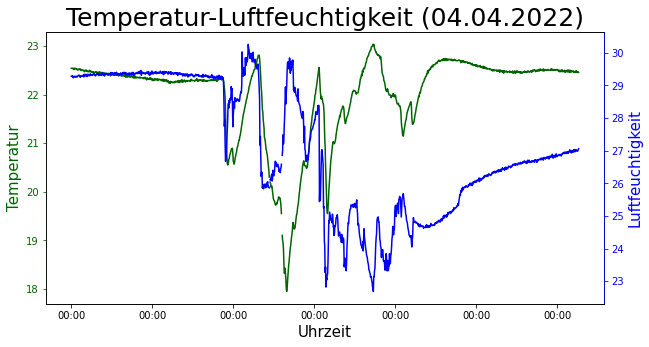

In [500]:
fig,ax1 = plt.subplots(figsize=(10,5))

ax1.plot(df0404.index.values, df0404["device1temp"], color="darkgreen")

ax2 = ax1.twinx()

ax2.plot(df0404.index.values, df0404["device1humidity"], color="blue")

ax1.set_ylabel("Temperatur", color="darkgreen", fontsize = 15)
ax2.set_ylabel("Luftfeuchtigkeit", color="blue", fontsize = 15)
ax1.set_xlabel("Uhrzeit", color="black", fontsize = 15)

myFmt = mdates.DateFormatter("%H:%M")
ax2.xaxis.set_major_formatter(myFmt)

ax1.spines["left"].set_color("darkgreen")
ax2.spines["right"].set_color("blue")
ax1.tick_params(axis="y", colors="darkgreen")
ax2.tick_params(axis="y", colors="blue")
ax1.set_title("Temperatur-Luftfeuchtigkeit (04.04.2022)", fontsize=25)

In [501]:
mask = (df.index > pd.to_datetime("25042022 00:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("29042022 23:59:59", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))

df25_29 = df[mask]

In [502]:
df25_29

,entryid,device1humidity,device1co2,device1temp,device2humidity,device2co2,device2temp,device3humidity,device3co2,device3temp,...,device2light,device3light,device1battery,device2battery,device3battery,numberOfPeople,subject,fensterOffen,fensterGekippt,fensterKombination
inserttime,,,,,,,,,,,,,,,,,,,,,
2022-04-25 00:00:38+00:00,31106,NaN,NaN,NaN,NaN,NaN,NaN,31.9290,420.825,25.3952,...,NaN,0.009894,NaN,NaN,3.84946,0,Nichts,0.0,0.0,0.0
2022-04-25 00:01:31+00:00,31107,NaN,NaN,NaN,NaN,NaN,NaN,31.9153,421.508,25.3792,...,NaN,0.034629,NaN,NaN,3.8543,0,Nichts,0.0,0.0,0.0
2022-04-25 00:02:21+00:00,31108,NaN,NaN,NaN,NaN,NaN,NaN,31.8970,423.122,25.3658,...,NaN,0.014841,NaN,NaN,3.8543,0,Nichts,0.0,0.0,0.0
2022-04-25 00:03:12+00:00,31109,NaN,NaN,NaN,NaN,NaN,NaN,31.8832,422.709,25.3792,...,NaN,0.034629,NaN,NaN,3.8543,0,Nichts,0.0,0.0,0.0
2022-04-25 00:04:02+00:00,31110,NaN,NaN,NaN,NaN,NaN,NaN,31.8558,423.284,25.3792,...,NaN,0.029682,NaN,NaN,3.85591,0,Nichts,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29 23:55:52+00:00,39463,NaN,NaN,NaN,NaN,NaN,NaN,34.0454,525.135,25.4513,...,NaN,0.034629,NaN,NaN,3.66577,0,Nichts,0.0,0.0,0.0
2022-04-29 23:56:44+00:00,39464,NaN,NaN,NaN,NaN,NaN,NaN,34.0988,526.736,25.4513,...,NaN,0.009894,NaN,NaN,3.66899,0,Nichts,0.0,0.0,0.0
2022-04-29 23:57:35+00:00,39465,NaN,NaN,NaN,NaN,NaN,NaN,34.0866,527.280,25.4513,...,NaN,0.029682,NaN,NaN,3.66899,0,Nichts,0.0,0.0,0.0


Text(0.5, 1.0, 'Temperatur-Luftfeuchtigkeit (25.04-29.04)')

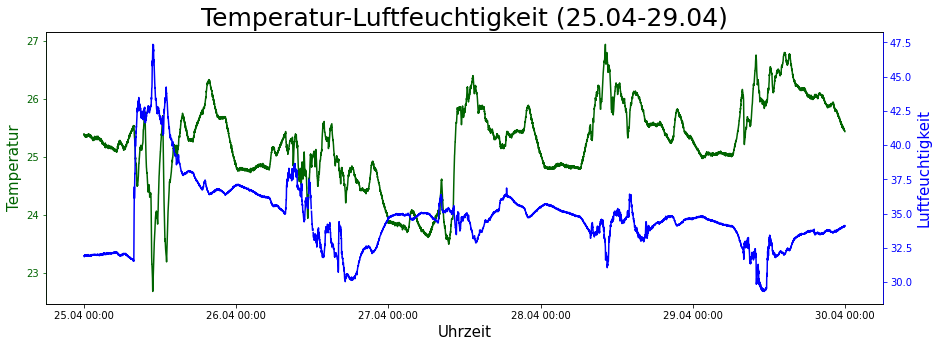

In [503]:
fig,ax1 = plt.subplots(figsize=(15,5))

ax1.plot(df25_29.index.values, df25_29["device3temp"], color="darkgreen")

ax2 = ax1.twinx()

ax2.plot(df25_29.index.values, df25_29["device3humidity"], color="blue")

ax1.set_ylabel("Temperatur", color="darkgreen", fontsize = 15)
ax2.set_ylabel("Luftfeuchtigkeit", color="blue", fontsize = 15)
ax1.set_xlabel("Uhrzeit", color="black", fontsize = 15)

myFmt = mdates.DateFormatter("%d.%m %H:%M")
ax2.xaxis.set_major_formatter(myFmt)

ax1.spines["left"].set_color("darkgreen")
ax2.spines["right"].set_color("blue")
ax1.tick_params(axis="y", colors="darkgreen")
ax2.tick_params(axis="y", colors="blue")
ax1.set_title("Temperatur-Luftfeuchtigkeit (25.04-29.04)", fontsize=25)

In [549]:
df25_29.reset_index(inplace=True)

start   = df25_29["inserttime"][:-1]
end     = df25_29["inserttime"][1:]
colors  = df25_29["fensterKombination"][:-1]

start.reset_index(inplace = True, drop = True)
end.reset_index(inplace = True, drop = True)
colors.reset_index(inplace = True, drop = True)

dffenster = pd.DataFrame({"start":start, "end":end, "colors": colors})

df25_29 = df25_29[:-1]
df25_29["fensterKombination"] = df25_29["fensterKombination"].astype("category")

<ipython-input-549-31fd3dbe4a18>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


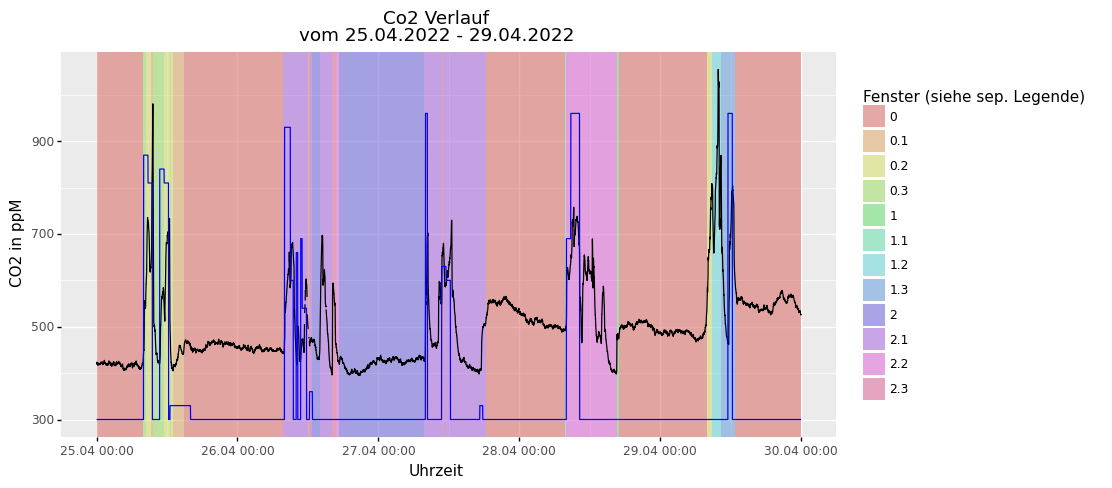

<ggplot: (8769701756694)>

In [550]:
(ggplot()
    + geom_rect(dffenster, aes(xmin = start, xmax = end, ymin = float("-inf"), ymax = float("inf"), fill = colors), alpha = 0.5)
    + geom_line(df25_29, aes("inserttime", "device3co2"))
    + geom_line(df25_29, aes("inserttime", "30*numberOfPeople+300"), color = "blue")
    + scale_x_date(date_labels = "%d.%m %H:%M")
    + labs(title = "Co2 Verlauf\nvom 25.04.2022 - 29.04.2022",x = "Uhrzeit", y = "CO2 in ppM", fill = "Fenster (siehe sep. Legende)")
    + theme(figure_size=(10, 5))
    )

In [506]:
df25_29

,inserttime,entryid,device1humidity,device1co2,device1temp,device2humidity,device2co2,device2temp,device3humidity,device3co2,...,device2light,device3light,device1battery,device2battery,device3battery,numberOfPeople,subject,fensterOffen,fensterGekippt,fensterKombination
0,2022-04-25 00:00:38+00:00,31106,NaN,NaN,NaN,NaN,NaN,NaN,31.9290,420.825,...,NaN,0.009894,NaN,NaN,3.84946,0,Nichts,0.0,0.0,0.0
1,2022-04-25 00:01:31+00:00,31107,NaN,NaN,NaN,NaN,NaN,NaN,31.9153,421.508,...,NaN,0.034629,NaN,NaN,3.8543,0,Nichts,0.0,0.0,0.0
2,2022-04-25 00:02:21+00:00,31108,NaN,NaN,NaN,NaN,NaN,NaN,31.8970,423.122,...,NaN,0.014841,NaN,NaN,3.8543,0,Nichts,0.0,0.0,0.0
3,2022-04-25 00:03:12+00:00,31109,NaN,NaN,NaN,NaN,NaN,NaN,31.8832,422.709,...,NaN,0.034629,NaN,NaN,3.8543,0,Nichts,0.0,0.0,0.0
4,2022-04-25 00:04:02+00:00,31110,NaN,NaN,NaN,NaN,NaN,NaN,31.8558,423.284,...,NaN,0.029682,NaN,NaN,3.85591,0,Nichts,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8356,2022-04-29 23:55:00+00:00,39462,NaN,NaN,NaN,NaN,NaN,NaN,34.0866,525.767,...,NaN,0.034629,NaN,NaN,3.67383,0,Nichts,0.0,0.0,0.0
8357,2022-04-29 23:55:52+00:00,39463,NaN,NaN,NaN,NaN,NaN,NaN,34.0454,525.135,...,NaN,0.034629,NaN,NaN,3.66577,0,Nichts,0.0,0.0,0.0
8358,2022-04-29 23:56:44+00:00,39464,NaN,NaN,NaN,NaN,NaN,NaN,34.0988,526.736,...,NaN,0.009894,NaN,NaN,3.66899,0,Nichts,0.0,0.0,0.0
8359,2022-04-29 23:57:35+00:00,39465,NaN,NaN,NaN,NaN,NaN,NaN,34.0866,527.280,...,NaN,0.029682,NaN,NaN,3.66899,0,Nichts,0.0,0.0,0.0


In [514]:
mask = (df.index > pd.to_datetime("29042022 07:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("29042022 16:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))

df29 = df[mask]

In [517]:
df29.reset_index(inplace=True)

start   = df29["inserttime"][:-1]
end     = df29["inserttime"][1:]
colors  = df29["fensterKombination"][:-1]

start.reset_index(inplace = True, drop = True)
end.reset_index(inplace = True, drop = True)
colors.reset_index(inplace = True, drop = True)

dffenster = pd.DataFrame({"start":start, "end":end, "colors": colors})

df29 = df29[:-1]

df29["fensterKombination"] = df29["fensterKombination"].astype("category")

<ipython-input-517-1d0ee2f29f1b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


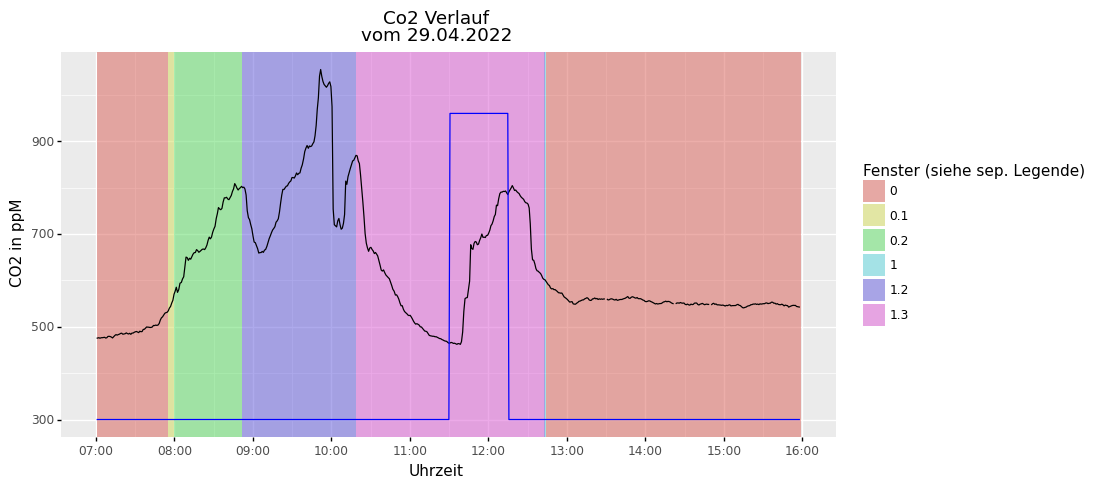

<ggplot: (8769650673333)>

In [518]:
(ggplot()
    + geom_rect(dffenster, aes(xmin = start, xmax = end, ymin = float("-inf"), ymax = float("inf"), fill = colors), alpha = 0.5)
    + geom_line(df29, aes("inserttime", "device3co2"))
    + geom_line(df29, aes("inserttime", "30*numberOfPeople+300"), color = "blue")
    + scale_x_date(date_labels = "%H:%M")
    + labs(title = "Co2 Verlauf\nvom 29.04.2022",x = "Uhrzeit", y = "CO2 in ppM", fill = "Fenster (siehe sep. Legende)")
    + theme(figure_size=(10, 5))
    )

In [544]:
mask = (df.index > pd.to_datetime("13042022 15:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC")) & \
        (df.index < pd.to_datetime("13042022 18:00:00", format="%d%m%Y %H:%M:%S").tz_localize("UTC"))

df13 = df[mask]

In [545]:
df13.reset_index(inplace=True)

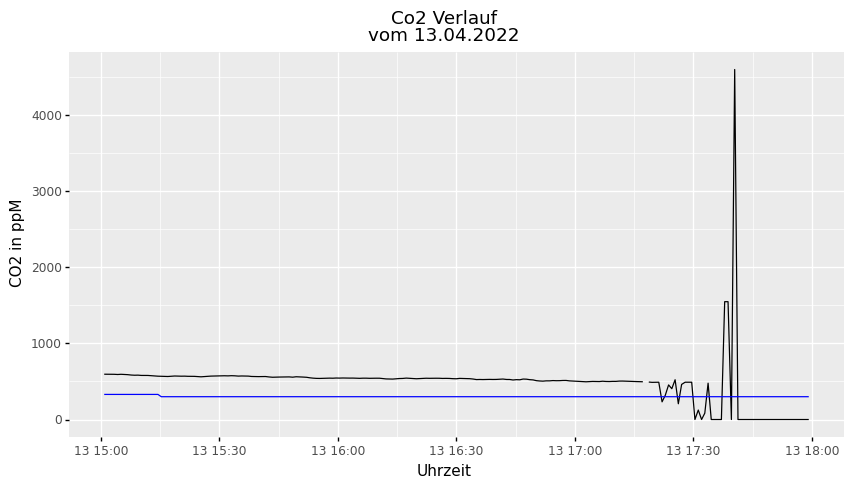

<ggplot: (8769714499973)>

In [546]:
(ggplot()
    + geom_line(df13, aes("inserttime", "device2co2"))
    + geom_line(df13, aes("inserttime", "30*numberOfPeople+300"), color = "blue")
    + scale_x_date(date_labels = "%d %H:%M")
    + labs(title = "Co2 Verlauf\nvom 13.04.2022",x = "Uhrzeit", y = "CO2 in ppM", fill = "Fenster (siehe sep. Legende)")
    + theme(figure_size=(10, 5))
    )